In [1]:
from src.utils import compute_average_pos_weight
from src.dataloaders.brats import BRATS
import torch
train_set = BRATS('../../../../special-course/data/BRATS_20_images', mode="train", subset=0.6, size=[64, 64, 155])
valid_set = BRATS('../../../../special-course/data/BRATS_20_images', mode='val', subset=0.6, size=[64, 64, 155])
test_set = BRATS('../../../../special-course/data/BRATS_20_images', mode='test', subset=0.6, size=[64, 64, 155])
test_set_hgg = BRATS('../../../../special-course/data/BRATS_20_images', mode='test-hgg', subset=0.6, size=[64, 64, 155])
test_set_lgg = BRATS('../../../../special-course/data/BRATS_20_images', mode='test-lgg', subset=0.6, size=[64, 64, 155])

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=False, drop_last=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, drop_last=True)
test_dataloader_hgg = torch.utils.data.DataLoader(test_set_hgg, batch_size=1, shuffle=True, drop_last=True)
test_dataloader_lgg = torch.utils.data.DataLoader(test_set_lgg, batch_size=1, shuffle=True, drop_last=True)

train = compute_average_pos_weight(train_dataloader)
val = compute_average_pos_weight(valid_dataloader)
test = compute_average_pos_weight(test_dataloader)
test_hgg = compute_average_pos_weight(test_dataloader_hgg)
test_lgg = compute_average_pos_weight(test_dataloader_lgg)
print('tr', train, 'val', val, 'test', test, 'test_hgg', test_hgg, 'test_lgg', test_lgg)
# train tensor([0.0115])
# val tensor([0.0093])
# test tensor([0.0088])
# test_hgg tensor([0.0103])
# test_lgg tensor([0.0074])

tr tensor([0.0115]) val tensor([0.0093]) test tensor([0.0088]) test_hgg tensor([0.0103]) test_lgg tensor([0.0074])


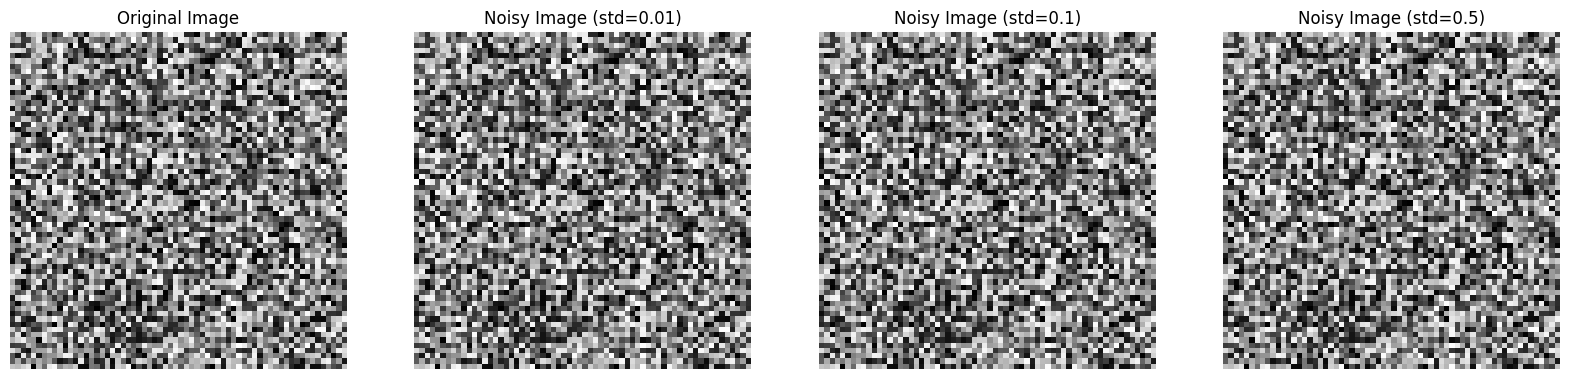

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# Create a sample image
original_image = np.random.rand(64, 64) * 255  # Example 64x64 image with values in [0, 255]

# Add noise with different std values
std_values = [0.01, 0.1, 0.5]
noisy_images = [add_gaussian_noise(original_image, std=std) for std in std_values]

# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, (noisy_image, std) in enumerate(zip(noisy_images, std_values)):
    axes[i + 1].imshow(noisy_image, cmap='gray')
    axes[i + 1].set_title(f'Noisy Image (std={std})')
    axes[i + 1].axis('off')

plt.show()


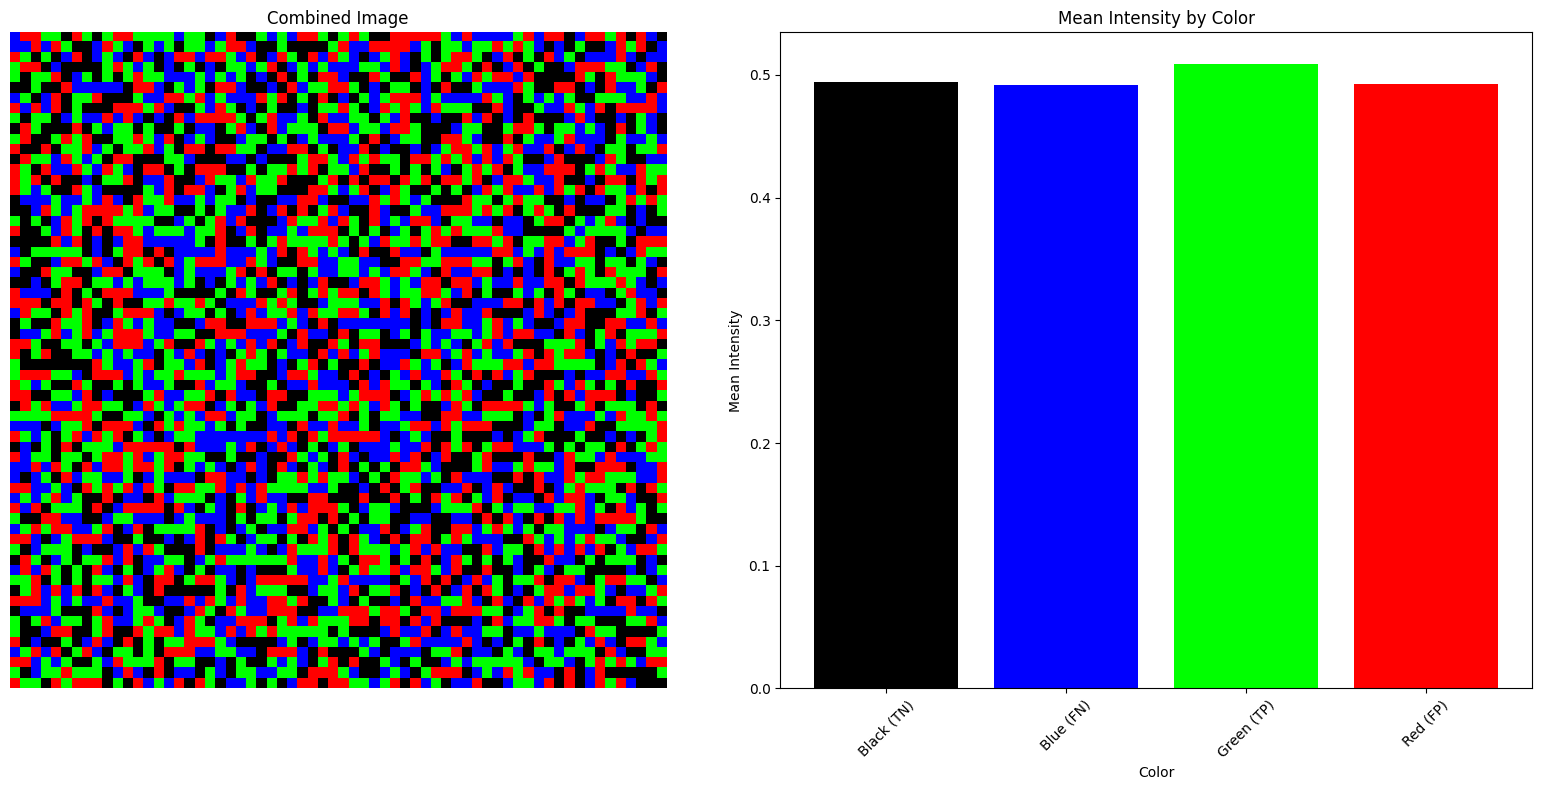

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Example intensity array (values between 0 and 1)
intensity_array = np.random.rand(64, 64)

# Combined image with specific RGB values for different cases
combined_image = np.zeros((64, 64, 3), dtype=np.uint8)
np_target = np.random.randint(0, 2, (64, 64))
cur_pred = np.random.randint(0, 2, (64, 64))

combined_image[(np_target == 1) & (cur_pred == 1)] = [0, 255, 0]   # tp - green
combined_image[(np_target == 0) & (cur_pred == 1)] = [255, 0, 0]   # fp - red
combined_image[(np_target == 0) & (cur_pred == 0)] = [0, 0, 0]     # tn - black
combined_image[(np_target == 1) & (cur_pred == 0)] = [0, 0, 255]   # fn - blue

# Define color map corresponding to the RGB values
color_map = {
    (0, 255, 0): 'Green (TP)',
    (255, 0, 0): 'Red (FP)',
    (0, 0, 0): 'Black (TN)',
    (0, 0, 255): 'Blue (FN)'
}

# Extract unique colors and their corresponding intensity values
unique_colors = np.unique(combined_image.reshape(-1, 3), axis=0)
mean_intensities = []

for color in unique_colors:
    mask = np.all(combined_image == color, axis=-1)
    mean_intensity = np.mean(intensity_array[mask])
    mean_intensities.append(mean_intensity)

# Normalize the unique colors to be within 0-1 range
normalized_colors = unique_colors / 255.0

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Display the combined image in the first subplot
axes[0].imshow(combined_image)
axes[0].axis('off')
axes[0].set_title('Combined Image')

# Create a bar plot in the second subplot
bars = axes[1].bar(range(len(unique_colors)), mean_intensities, color=normalized_colors)
axes[1].set_xticks(range(len(unique_colors)))
axes[1].set_xticklabels([color_map[tuple(color)] for color in unique_colors], rotation=45)
axes[1].set_xlabel('Color')
axes[1].set_ylabel('Mean Intensity')
axes[1].set_title('Mean Intensity by Color')

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


mean False
ent False
target True


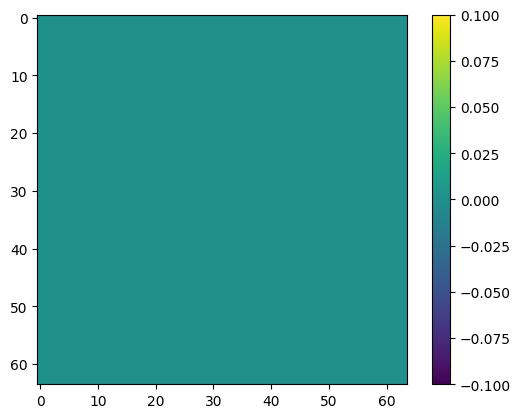

In [21]:
import numpy as np
import matplotlib.pyplot as plt

mean = np.load('mean_0_4.npy')
ent = np.load('entropy_0_4.npy')
targ = np.load('target_e0_b15.npy')
targ = targ[0, 0, :, :]
# mean = (mean > 0.5).astype(np.uint8)  # Or np.bool_ for boolean array

print('mean', len(np.unique(mean)) <= 2)
print('ent', len(np.unique(ent)) <= 2)
print('target', len(np.unique(targ)) <= 2)
plt.imshow(targ)
plt.colorbar()
# fig, axes = plt.subplots(1, 2, figsize=(20, 4))
# axes[0].imshow(ent)
# axes[1].imshow(mean)

In [44]:
def entropy_pixelwise(image):
    entropy_image = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            p = image[i, j]
            if p == 0 or p == 1:
                entropy_val = 0.0
            else:
                entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
            # cur_val = image[i, j]/ 255.0
            # if cur_val == 0:
            #     entropy_val = 0
            # else:
            #     entropy_val = -cur_val * np.log2(cur_val)
            entropy_image[i, j] = entropy_val
    return entropy_image


img (16, 4, 64, 64) False
targ (64, 64) True
pred (64, 64) False
pred after (64, 64) True


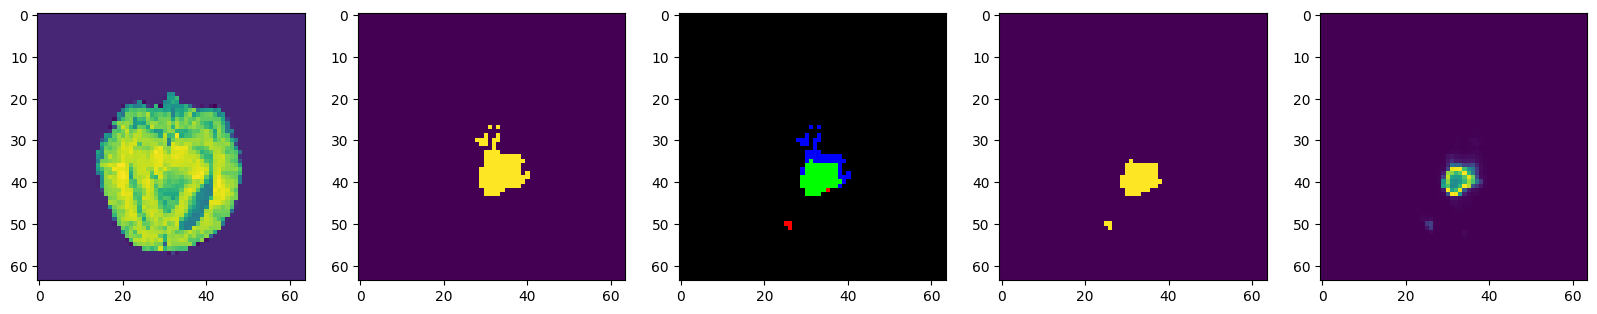

In [49]:
import numpy as np
import matplotlib.pyplot as plt

pred = np.load('pred_23.npy')
img = np.load('img_23.npy')
targ = np.load('tar_23.npy')
targ = targ[0, 0, :, :]

print('img',img.shape, len(np.unique(img)) <= 2)
print('targ',targ.shape, len(np.unique(targ)) <= 2)
print('pred', pred.shape, len(np.unique(pred)) <= 2)

# plt.imshow(pred)
# plt.colorbar()
cur_entropy = entropy_pixelwise(pred)

pred = (pred > 0.01).astype(np.uint8)  # Or np.bool_ for boolean array
print('pred after', pred.shape, len(np.unique(pred)) <= 2)

combined_image = np.zeros((64, 64, 3), dtype=np.uint8)
combined_image[(targ == 1) & (pred == 1)] = [0, 255, 0] # tp - green
combined_image[(targ == 0) & (pred == 1)] = [255, 0, 0] # fp - red
combined_image[(targ == 0) & (pred == 0)] = [0, 0, 0] #tn - black
combined_image[(targ == 1) & (pred == 0)] = [0, 0, 255] # fn - blue

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes[0].imshow(img[0, 1, :, :])
# axes[1].imshow(img[1, 1, :, :])
# axes[2].imshow(img[2, 1, :, :])
# axes[3].imshow(img[3, 1, :, :])
axes[1].imshow(targ)
axes[2].imshow(combined_image)
axes[3].imshow(pred)
axes[4].imshow(cur_entropy)

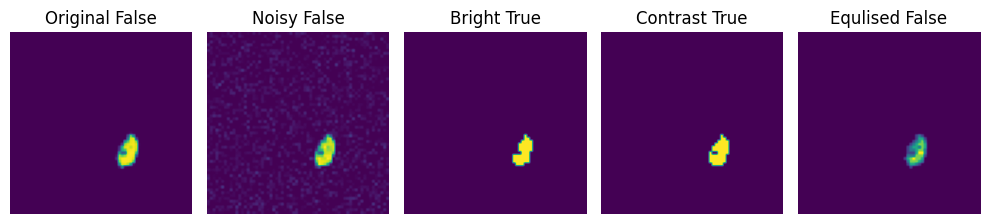

In [18]:
import numpy as np

def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image


def adjust_brightness(image_array, factor):
    brightened_image = np.clip(image_array * factor, 0, 255)
    return brightened_image.astype(np.uint8)

def adjust_contrast(image_array, factor):
    mean = np.mean(image_array)
    contrasted_image = np.clip((image_array - mean) * factor + mean, 0, 255)
    return contrasted_image.astype(np.uint8)

def apply_gamma_correction(image_array, gamma):
    gamma_corrected_image = np.clip(255 * (image_array / 255.0) ** gamma, 0, 255)
    return gamma_corrected_image.astype(np.uint8)

def add_noise(image_array, noise_type="gaussian", mean=0, var=0.01):
    if noise_type == "gaussian":
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, image_array.shape)
        noisy_image = np.clip(image_array + gauss * 255, 0, 255)
        return noisy_image.astype(np.uint8)

def apply_filter(image_array, kernel):
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2
    padded_image = np.pad(image_array, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    filtered_image = np.zeros_like(image_array)

    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            for k in range(image_array.shape[2]):
                filtered_image[i, j, k] = np.sum(kernel * padded_image[i:i+kernel_size, j:j+kernel_size, k])

    return np.clip(filtered_image, 0, 255).astype(np.uint8)

def equalize_histogram(image_array):
    if len(image_array.shape) == 2:  # Grayscale image
        histogram, bins = np.histogram(image_array.flatten(), 256, density=True)
        cdf = histogram.cumsum()
        cdf_normalized = cdf * 255 / cdf[-1]
        equalized_image = np.interp(image_array.flatten(), bins[:-1], cdf_normalized)
        return equalized_image.reshape(image_array.shape).astype(np.uint8)
    else:  # Color image
        ycrcb = np.dot(image_array[...,:3], [0.299, 0.587, 0.114])
        y = ycrcb
        histogram, bins = np.histogram(y.flatten(), 256, density=True)
        cdf = histogram.cumsum()
        cdf_normalized = cdf * 255 / cdf[-1]
        y_equalized = np.interp(y.flatten(), bins[:-1], cdf_normalized).reshape(y.shape)
        equalized_image = np.stack((y_equalized, y_equalized, y_equalized), axis=-1)
        return equalized_image.astype(np.uint8)

def gaussian_kernel(size, sigma=1):
    x, y = np.meshgrid(np.linspace(-size // 2, size // 2, size), np.linspace(-size // 2, size // 2, size))
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

def apply_blur(image_array, ksize=5):
    kernel = gaussian_kernel(ksize, sigma=ksize/6)
    return apply_filter(image_array, kernel)



noisy_image = add_gaussian_noise(mean, mean=0, std=0.05)
brightened_image = adjust_brightness(mean, 1.5)  # Increase brightness by 50%
contrasted_image = adjust_contrast(mean, 2.0)  # Increase contrast by 100%
gamma_corrcted_image = apply_gamma_correction(mean, 2.0)  # Apply gamma correction with gamma = 2.0
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], np.float32)  # Example kernel
# filtered_image = apply_filter(mean, kernel)
equalized_image = equalize_histogram(mean)
# blurred_image = apply_blur(mean, ksize=5)

# Plot the original and noisy images
fig, axes = plt.subplots(1, 5, figsize=(10, 10))
axes[0].imshow(mean)
axes[0].set_title(f'Original {len(np.unique(mean)) <= 2}')
axes[0].axis('off')

axes[1].imshow(noisy_image)
axes[1].set_title(f'Noisy {len(np.unique(noisy_image)) <= 2}')
axes[1].axis('off')

axes[2].imshow(brightened_image)
axes[2].set_title(f'Bright {len(np.unique(brightened_image)) <= 2}')
axes[2].axis('off')

axes[3].imshow(contrasted_image)
axes[3].set_title(f'Contrast {len(np.unique(contrasted_image)) <= 2}')
axes[3].axis('off')

axes[4].imshow(equalized_image)
axes[4].set_title(f'Equlised {len(np.unique(equalized_image)) <= 2}')
axes[4].axis('off')

# axes[6].imshow(mean, cmap='gray')
# axes[6].set_title('NOT WORK FILTER Image')
# axes[6].axis('off')

# axes[8].imshow(blurred_image, cmap='gray')
# axes[8].set_title('Blur Image')
# axes[8].axis('off')

plt.tight_layout()
plt.show()


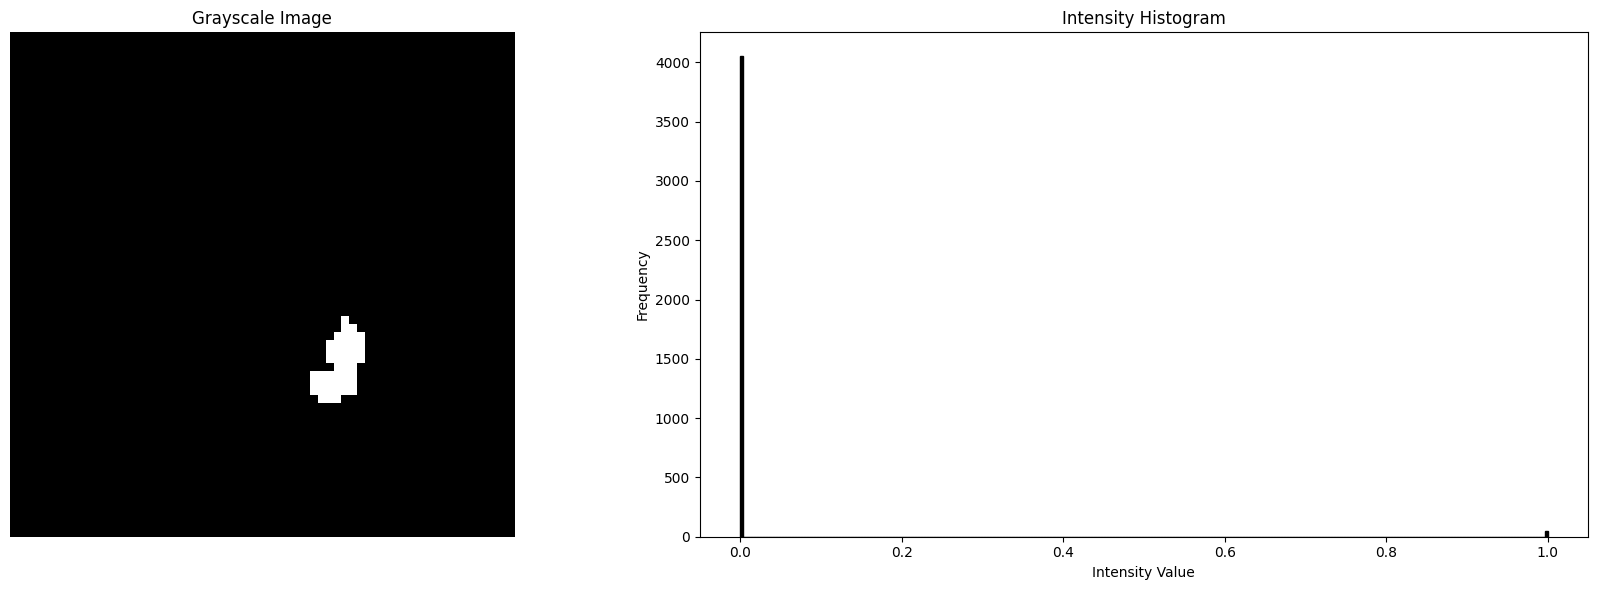

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

cur_im = brightened_image
ax1.imshow(cur_im, cmap='gray', vmin=0, vmax=1)
ax1.set_title('Grayscale Image')
ax1.axis('off')

# Plot the intensity histogram
hist_values, bins, _ = ax2.hist(cur_im.ravel(), bins=256, range=(0, 1), color='black', edgecolor='black')
ax2.set_title('Intensity Histogram')
ax2.set_xlabel('Intensity Value')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

im (4096,) False
0.011535345
Entropy: 0.09080781466735607 -1.4426951601859516e-10 Mean 0.011535345
image False
(64, 64) 0 False
Entropy in function 42.02058379031021


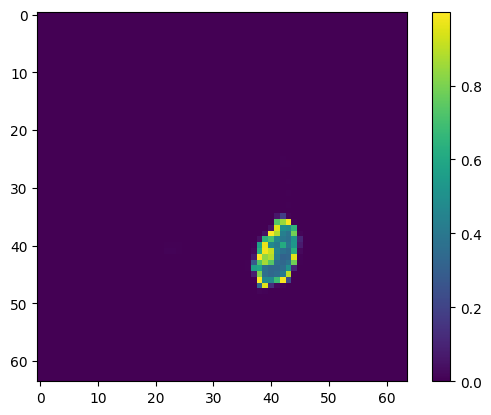

In [2]:
def scale_and_format(value, scale_factor=1e6, precision=1):
    # Scale the value
    scaled_value = value * scale_factor
    # Format the value to the desired precision
    formatted_value = f"{scaled_value:.{precision}f}"
    return formatted_value

def entropy_pixelwise(image):
    print(image.shape)
    hist, _ = np.histogram(image, bins=np.arange(1))
    print(len(hist), hist)
    hist = hist / hist.sum()
    # print(len(hist), hist)
    entropy = - np.sum(hist * np.log2(hist + 1e-10))
    print(entropy)
    entropy_map = np.zeros_like(image, dtype=np.float32)
    entropy_map[:] = entropy
    # entropy_map = np.full_like(image, entropy, dtype=np.float32)
    print(entropy_map.shape)
    return entropy_map

def entropy_pixelwise2(image):
    entropy_sum = 0.0
    print('image', len(np.unique(image)) <= 2)
    entropy_image = np.zeros_like(image, dtype=np.float32)
    couter = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            p = image[i, j]
            if p == 0 or p == 1:
                entropy_val = 0.0
            else:
                entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
                # entropy_val = -(p * np.log2(p))
            # print(i, j, scale_and_format(p), scale_and_format(entropy_val))
            entropy_image[i, j] = entropy_val
            entropy_sum += entropy_val
    print(entropy_image.shape, couter, len(np.unique(entropy_image)) <= 2)
    print('Entropy in function', entropy_sum)
    return entropy_image

def get_entropy2(image):
    hist, _ = np.histogram(image, bins=[0, 1, 2])     # Compute histogram of intensity values (0 and 1)
    probs = hist / np.sum(hist)     # Normalize histogram to get probability distribution
    entropy = -np.sum(probs * np.log2(probs + 1e-10))  # Add a small value to avoid log(0)
    return entropy

def get_entropy(image):
    flat_image = image.flatten()
    print('im', flat_image.shape, np.array_equal(flat_image, flat_image.astype(bool)))
    p = np.mean(flat_image)
    print(p)
    if p == 0 or p == 1:
        entropy_val = 0.0
    else:
        entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    return entropy_val
print('Entropy:', get_entropy(mean), get_entropy2(mean), 'Mean', np.mean(mean))
entr = entropy_pixelwise2(mean)
plt.imshow(entr)#, vmin=0, vmax=1)
plt.colorbar()

In [67]:
np.log2(0.0)

/var/folders/m9/0pk11y017592qt_xmrzcrbkr0000gn/T/ipykernel_7992/3676528744.py:1: RuntimeWarning: divide by zero encountered in log2
  np.log2(0.0)


-inf

100 [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.8

/var/folders/m9/0pk11y017592qt_xmrzcrbkr0000gn/T/ipykernel_7992/1330570682.py:3: RuntimeWarning: divide by zero encountered in log2
  entro = -(im * np.log2(im))
/var/folders/m9/0pk11y017592qt_xmrzcrbkr0000gn/T/ipykernel_7992/1330570682.py:3: RuntimeWarning: invalid value encountered in multiply
  entro = -(im * np.log2(im))


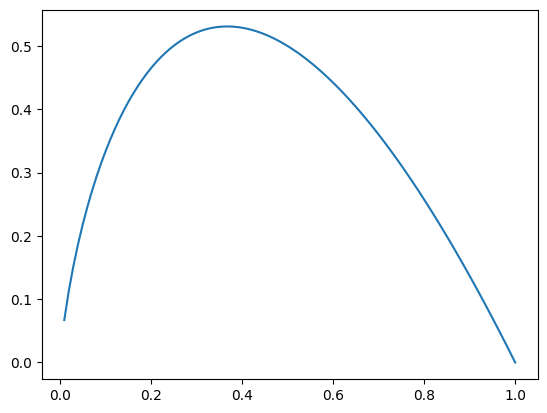

In [68]:
im = np.linspace(0,1,100)
print(len(im), im)
entro = -(im * np.log2(im))
print(len(entro), entro)

plt.plot(im, entro)

100 [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.8

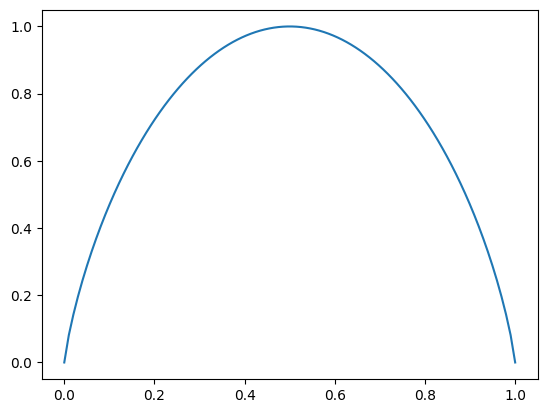

In [69]:
def binary_entropy(p):
    if p == 0 or p == 1:
        return 0.0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

# Example usage
# probabilities = np.array([0.1, 0.5, 0.9])
im = np.linspace(0,1,100)
print(len(im), im)
# entro = binary_entropy(im)
entro = np.array([binary_entropy(p) for p in im])
print(len(entro), entro)

plt.plot(im, entro)

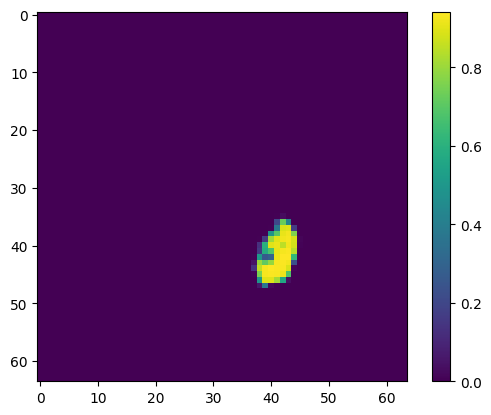

In [42]:
plt.imshow(mean)#, vmin=0, vmax=1)
plt.colorbar()

In [42]:
import numpy as np

image = np.load('../../../results/res-fancy-dawn-116/model_2/pred/pred_e0_b15.npy')
image = image[0, 0, :, :]

mask = np.ones((3, 3)) / 9  # 3x3 averaging mask (sum of elements = 1 for normalization)

padded_image = np.pad(image, ((1, 1), (1, 1)), mode='edge')

mean_values = np.zeros_like(image, dtype=float)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        neighborhood = padded_image[i:i+3, j:j+3]
        val = np.sum(neighborhood * mask)
        mean_values[i, j] = val
        if val > 0.0:
            print(i, j, val)
print(mean_values.shape)  # Output shape: (64, 64)

def mean_pixelwise(image, mask_size=3):
    mask = np.ones((mask_size, mask_size)) / mask_size*mask_size
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='edge')
    mean_values = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i+3, j:j+3]
            val = np.sum(neighborhood * mask)
            mean_values[i, j] = val
    return mean_values
print(mean_values.shape)

11 22 0.1111111111111111
11 23 0.2222222222222222
11 24 0.3333333333333333
11 25 0.3333333333333333
11 26 0.3333333333333333
11 27 0.3333333333333333
11 28 0.3333333333333333
11 29 0.3333333333333333
11 30 0.3333333333333333
11 31 0.3333333333333333
11 32 0.3333333333333333
11 33 0.3333333333333333
11 34 0.3333333333333333
11 35 0.3333333333333333
11 36 0.3333333333333333
11 37 0.3333333333333333
11 38 0.2222222222222222
11 39 0.1111111111111111
12 19 0.1111111111111111
12 20 0.2222222222222222
12 21 0.3333333333333333
12 22 0.4444444444444444
12 23 0.5555555555555556
12 24 0.6666666666666667
12 25 0.6666666666666667
12 26 0.6666666666666667
12 27 0.6666666666666667
12 28 0.6666666666666667
12 29 0.6666666666666667
12 30 0.6666666666666667
12 31 0.6666666666666667
12 32 0.6666666666666667
12 33 0.6666666666666667
12 34 0.6666666666666667
12 35 0.6666666666666667
12 36 0.6666666666666667
12 37 0.6666666666666667
12 38 0.5555555555555556
12 39 0.3333333333333333
12 40 0.1111111111111111


In [15]:
from pathlib import Path

def custom_sort_key(filename):
    filename_str = str(filename)
    num_e = int(filename_str.split("_e")[1].split("_b")[0])
    num_b = int(filename_str.split("_b")[1].split(".")[0])
    return num_e, num_b

def is_binary_image(image_array):
    unique_values = np.unique(image_array)
    if len(unique_values) <= 2:
        return True
    else:
        return False


def get_entropy(image):
    hist, _ = np.histogram(image, bins=[0, 1, 2])     # Compute histogram of intensity values (0 and 1)
    probs = hist / np.sum(hist)     # Normalize histogram to get probability distribution
    entropy = -np.sum(probs * np.log2(probs + 1e-10))  # Add a small value to avoid log(0)
    return entropy


def get_std(image):
    return np.std(image)

def get_mean(image):
    return np.mean(image)



meean (64,)
11 22 1.0
11 23 2.0
11 24 3.0
11 25 3.0
11 26 3.0
11 27 3.0
11 28 3.0
11 29 3.0
11 30 3.0
11 31 3.0
11 32 3.0
11 33 3.0
11 34 3.0
11 35 3.0
11 36 3.0
11 37 3.0
11 38 2.0
11 39 1.0
12 19 1.0
12 20 2.0
12 21 3.0
12 22 4.0
12 23 5.0
12 24 6.0
12 25 6.0
12 26 6.0
12 27 6.0
12 28 6.0
12 29 6.0
12 30 6.0
12 31 6.0
12 32 6.0
12 33 6.0
12 34 6.0
12 35 6.0
12 36 6.0
12 37 6.0
12 38 5.0
12 39 3.0
12 40 1.0
13 18 1.0
13 19 3.0
13 20 5.0
13 21 6.0
13 22 7.0
13 23 8.0
13 24 9.0
13 25 9.0
13 26 9.0
13 27 9.0
13 28 9.0
13 29 9.0
13 30 9.0
13 31 9.0
13 32 9.0
13 33 9.0
13 34 9.0
13 35 9.0
13 36 9.0
13 37 9.0
13 38 8.0
13 39 6.0
13 40 4.0
13 41 2.0
13 42 1.0
14 17 1.0
14 18 2.0
14 19 5.0
14 20 6.0
14 21 8.0
14 22 8.0
14 23 9.0
14 24 9.0
14 25 9.0
14 26 9.0
14 27 9.0
14 28 9.0
14 29 9.0
14 30 9.0
14 31 9.0
14 32 9.0
14 33 9.0
14 34 9.0
14 35 9.0
14 36 9.0
14 37 9.0
14 38 9.0
14 39 8.0
14 40 7.0
14 41 5.0
14 42 3.0
14 43 1.0
15 16 1.0
15 17 2.0
15 18 4.0
15 19 5.0
15 20 6.0
15 21 7.0
15 22 8.

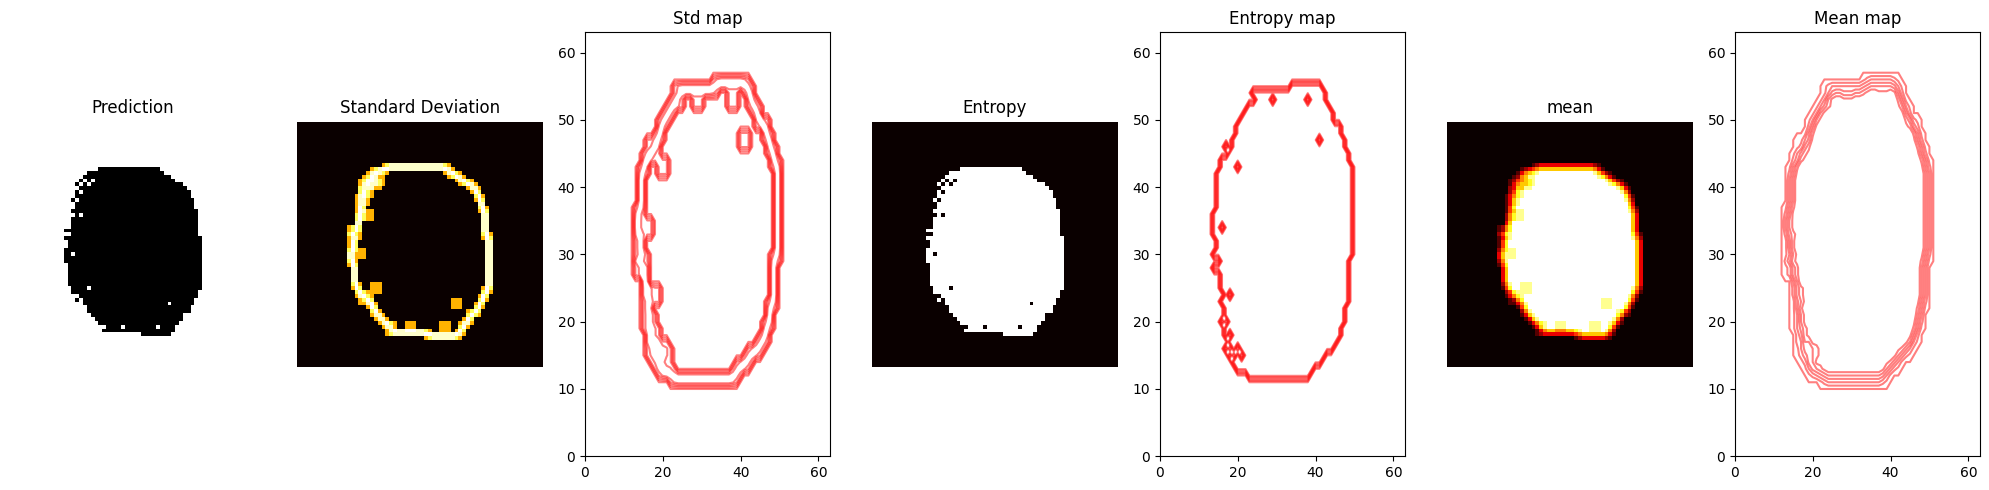

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def get_pixelwise_entropy(image):
    # image = image.astype(np.uint8)
    entropy_map = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            hist, _ = np.histogram(image[i, j], bins=[0, 1, 2])
            probs = hist / np.sum(hist)
            entropy_map[i, j] = -np.sum(probs * np.log2(probs + 1e-10))
    return entropy_map

def get_pixelwise_std(image, neighborhood_size=3):
    padded_image = np.pad(image, (neighborhood_size//2, neighborhood_size//2), mode='constant')
    std_dev_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i+neighborhood_size, j:j+neighborhood_size]
            std_dev_image[i, j] = np.std(neighborhood)
    return std_dev_image

def get_mean_pixelwise(image):
    mean = np.mean(image, axis=0)
    print('meean', mean.shape)
    return mean

prediction = np.load('../../../results/res-fancy-dawn-116/model_2/pred/pred_e0_b15.npy')
prediction = prediction[0, 0, :, :]

std_dev_prediction = get_pixelwise_std(prediction)

def pixel_entropy(pixel_value):
    if pixel_value == 0:
        return 0  # Define entropy as 0 for pixels with value 0 to avoid division by zero
    else:
        return -pixel_value * np.log2(pixel_value)

# Calculate pixel-wise entropy
entropy_image = np.zeros_like(prediction, dtype=float)
for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
        entropy_image[i, j] = pixel_entropy(prediction[i, j] / 255.0)  # Normalize pixel value to range [0, 1]

mean_prediction = get_mean_pixelwise(prediction)
mean1 = np.mean(prediction, axis=0)
mean2 = np.mean(prediction, axis=1)


# Create a figure with four subplots arranged horizontally
fig, axs = plt.subplots(1, 7, figsize=(20, 5))

# Plot the original prediction image
axs[0].imshow(prediction, cmap='binary')
axs[0].set_title('Prediction')
axs[0].axis('off')

#
# Plot the standard deviation prediction image
axs[1].imshow(std_dev_prediction, cmap='hot')
axs[1].set_title('Standard Deviation')
axs[1].axis('off')

axs[2].contour(get_pixelwise_std(prediction), levels=5, colors='r', alpha=0.5, linewidths=1.5)
axs[2].set_title('Std map')

# Plot the entropy prediction image
axs[3].imshow(entropy_image, cmap='hot')
axs[3].set_title('Entropy')
axs[3].axis('off')

axs[4].contour(entropy_image, levels=5, colors='r', alpha=0.5, linewidths=1.5)
axs[4].set_title('Entropy map')

axs[5].imshow(mean_pixelwise(prediction), cmap='hot')
axs[5].set_title('mean')
axs[5].axis('off')

axs[6].contour(mean_pixelwise(prediction), levels=5, colors='r', alpha=0.5, linewidths=1.5)
axs[6].set_title('Mean map')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
mean_arr = []
for i in range(0, 64):
    mean_arr.append([])
    for j in range(0, 64):
        mean_arr[i].append(np.std(prediction[i, j]))
    print(i, mean_arr[i])
print('res', mean_arr)

0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0